# Premier League Football Data - EDA Part 2

## Team Performance Analysis

This notebook focuses on analyzing team performance metrics including:
- Goals scored and conceded by team
- Expected Goals (xG) analysis
- Team performance trends across seasons
- Top performing and underperforming teams

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [14, 7]
plt.rcParams['font.size'] = 11

# Data paths
DATA_DIR = Path('../data')
PROCESSED_DIR = DATA_DIR / 'processed'

# Load data
fixtures = pd.read_csv(PROCESSED_DIR / 'all_fixtures.csv')
team_stats = pd.read_csv(PROCESSED_DIR / 'all_team_stats.csv')

display(Markdown(f"""
✅ **Data loaded successfully!**

| Dataset | Shape |
|---------|-------|
| Fixtures | {fixtures.shape} |
| Team Stats | {team_stats.shape} |
"""))


✅ **Data loaded successfully!**

| Dataset | Shape |
|---------|-------|
| Fixtures | (2110, 20) |
| Team Stats | (120, 351) |


## 1. Calculate Team Aggregated Statistics

In [2]:
# Calculate goals and xG per team from fixtures
def calculate_team_stats(fixtures_df):
    """Calculate aggregated team statistics from fixtures."""
    
    # Home stats
    home_stats = fixtures_df.groupby('home_team').agg({
        'home_goals': 'sum',
        'away_goals': 'sum',
        'home_xg': 'sum',
        'away_xg': 'sum',
        'match_result': lambda x: (x == 2).sum()  # Home wins
    }).rename(columns={
        'home_goals': 'goals_for_home',
        'away_goals': 'goals_against_home',
        'home_xg': 'xg_for_home',
        'away_xg': 'xg_against_home',
        'match_result': 'home_wins'
    })
    home_stats['home_matches'] = fixtures_df.groupby('home_team').size()
    home_stats['home_draws'] = fixtures_df[fixtures_df['match_result'] == 1].groupby('home_team').size()
    home_stats['home_draws'] = home_stats['home_draws'].fillna(0).astype(int)
    
    # Away stats
    away_stats = fixtures_df.groupby('away_team').agg({
        'away_goals': 'sum',
        'home_goals': 'sum',
        'away_xg': 'sum',
        'home_xg': 'sum',
        'match_result': lambda x: (x == 0).sum()  # Away wins
    }).rename(columns={
        'away_goals': 'goals_for_away',
        'home_goals': 'goals_against_away',
        'away_xg': 'xg_for_away',
        'home_xg': 'xg_against_away',
        'match_result': 'away_wins'
    })
    away_stats['away_matches'] = fixtures_df.groupby('away_team').size()
    away_stats['away_draws'] = fixtures_df[fixtures_df['match_result'] == 1].groupby('away_team').size()
    away_stats['away_draws'] = away_stats['away_draws'].fillna(0).astype(int)
    
    # Combine - rename index before joining to ensure consistent naming
    home_stats.index.name = 'team'
    away_stats.index.name = 'team'
    team_agg = home_stats.join(away_stats, how='outer').fillna(0)
    
    # Calculate totals
    team_agg['goals_for'] = team_agg['goals_for_home'] + team_agg['goals_for_away']
    team_agg['goals_against'] = team_agg['goals_against_home'] + team_agg['goals_against_away']
    team_agg['xg_for'] = team_agg['xg_for_home'] + team_agg['xg_for_away']
    team_agg['xg_against'] = team_agg['xg_against_home'] + team_agg['xg_against_away']
    team_agg['wins'] = team_agg['home_wins'] + team_agg['away_wins']
    team_agg['draws'] = team_agg['home_draws'] + team_agg['away_draws']
    team_agg['matches'] = team_agg['home_matches'] + team_agg['away_matches']
    team_agg['losses'] = team_agg['matches'] - team_agg['wins'] - team_agg['draws']
    team_agg['points'] = team_agg['wins'] * 3 + team_agg['draws']
    team_agg['goal_diff'] = team_agg['goals_for'] - team_agg['goals_against']
    team_agg['xg_diff'] = team_agg['xg_for'] - team_agg['xg_against']
    
    return team_agg.reset_index()

team_agg = calculate_team_stats(fixtures)
display(Markdown(f"## 📊 Team Statistics Calculated: **{len(team_agg)}** teams"))
display(team_agg[['team', 'matches', 'wins', 'draws', 'losses', 'points', 'goals_for', 'goals_against', 'goal_diff']].sort_values('points', ascending=False).head(10))

## 📊 Team Statistics Calculated: **28** teams

,team,matches,wins,draws,losses,points,goals_for,goals_against,goal_diff
15,Manchester City,211,146,35,30,473,489.0,188.0,301.0
13,Liverpool,211,126,51,34,429,441.0,225.0,216.0
0,Arsenal,211,129,39,43,426,404.0,207.0,197.0
6,Chelsea,211,97,57,57,348,347.0,246.0,101.0
16,Manchester United,211,97,50,64,341,325.0,288.0,37.0
1,Aston Villa,211,99,41,71,338,325.0,282.0,43.0
23,Tottenham Hotspur,211,96,36,79,324,375.0,301.0,74.0
17,Newcastle United,211,91,50,70,323,343.0,293.0,50.0
4,Brighton & Hove Albion,211,74,70,67,292,306.0,292.0,14.0
26,West Ham United,211,74,48,89,270,292.0,332.0,-40.0


## 2. Top Scorers and Best Defenses

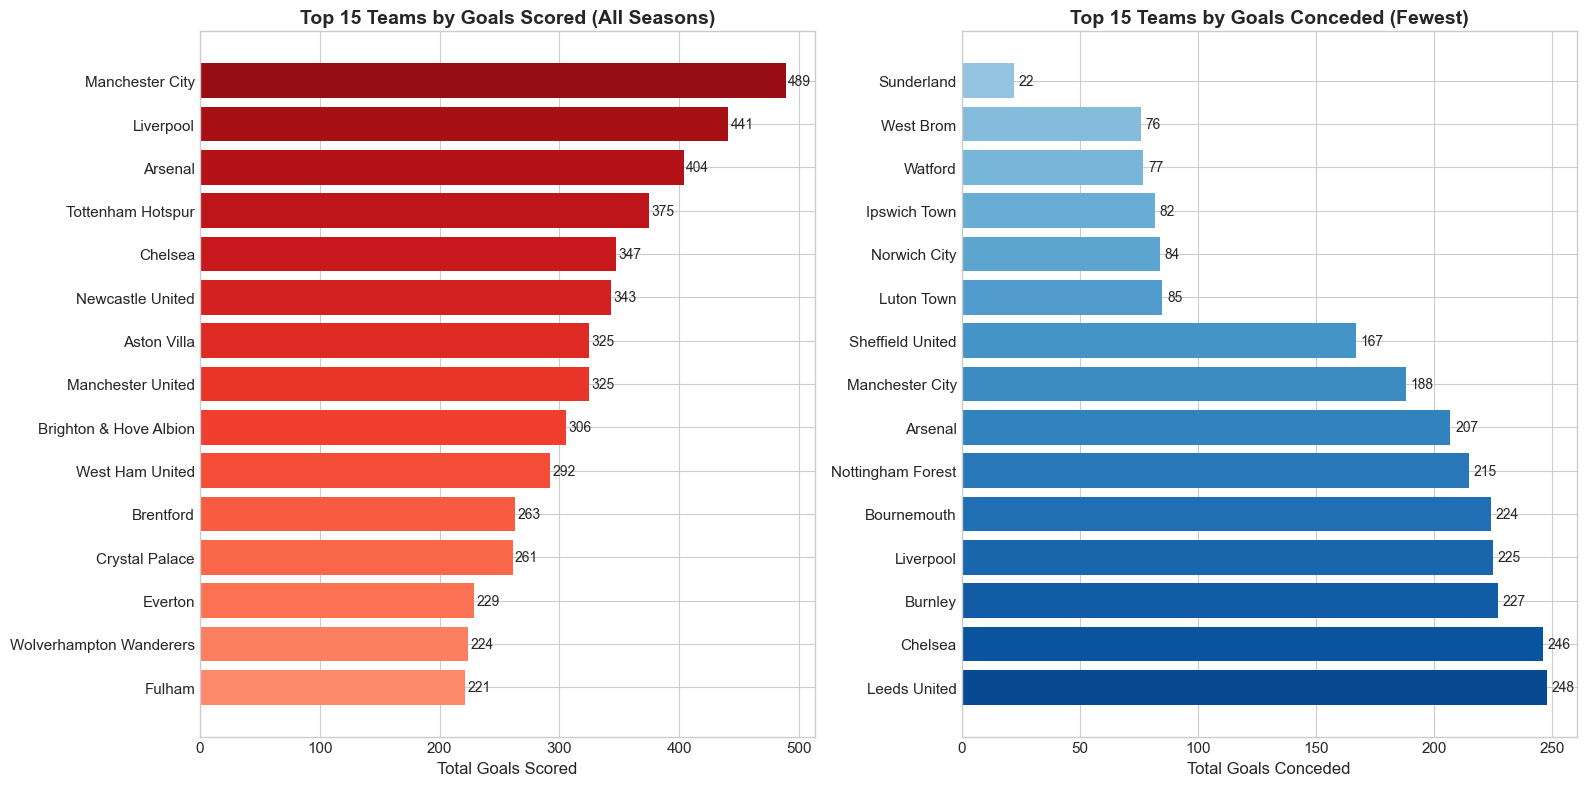

In [3]:
# Top 10 teams by goals scored
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Goals scored
top_scorers = team_agg.nlargest(15, 'goals_for')[['team', 'goals_for', 'matches']]
top_scorers['goals_per_match'] = top_scorers['goals_for'] / top_scorers['matches']

colors_attack = plt.cm.Reds(np.linspace(0.4, 0.9, len(top_scorers)))
bars1 = axes[0].barh(top_scorers['team'], top_scorers['goals_for'], color=colors_attack[::-1])
axes[0].set_xlabel('Total Goals Scored', fontsize=12)
axes[0].set_title('Top 15 Teams by Goals Scored (All Seasons)', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Add values
for bar, val in zip(bars1, top_scorers['goals_for']):
    axes[0].text(val + 2, bar.get_y() + bar.get_height()/2, f'{val:.0f}', 
                 va='center', fontsize=10)

# Goals conceded (lower is better)
best_defense = team_agg.nsmallest(15, 'goals_against')[['team', 'goals_against', 'matches']]
best_defense['goals_conceded_per_match'] = best_defense['goals_against'] / best_defense['matches']

colors_defense = plt.cm.Blues(np.linspace(0.4, 0.9, len(best_defense)))
bars2 = axes[1].barh(best_defense['team'], best_defense['goals_against'], color=colors_defense)
axes[1].set_xlabel('Total Goals Conceded', fontsize=12)
axes[1].set_title('Top 15 Teams by Goals Conceded (Fewest)', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

for bar, val in zip(bars2, best_defense['goals_against']):
    axes[1].text(val + 2, bar.get_y() + bar.get_height()/2, f'{val:.0f}', 
                 va='center', fontsize=10)

plt.tight_layout()
plt.savefig('../notebooks/figures/top_scorers_defense.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Expected Goals (xG) Analysis

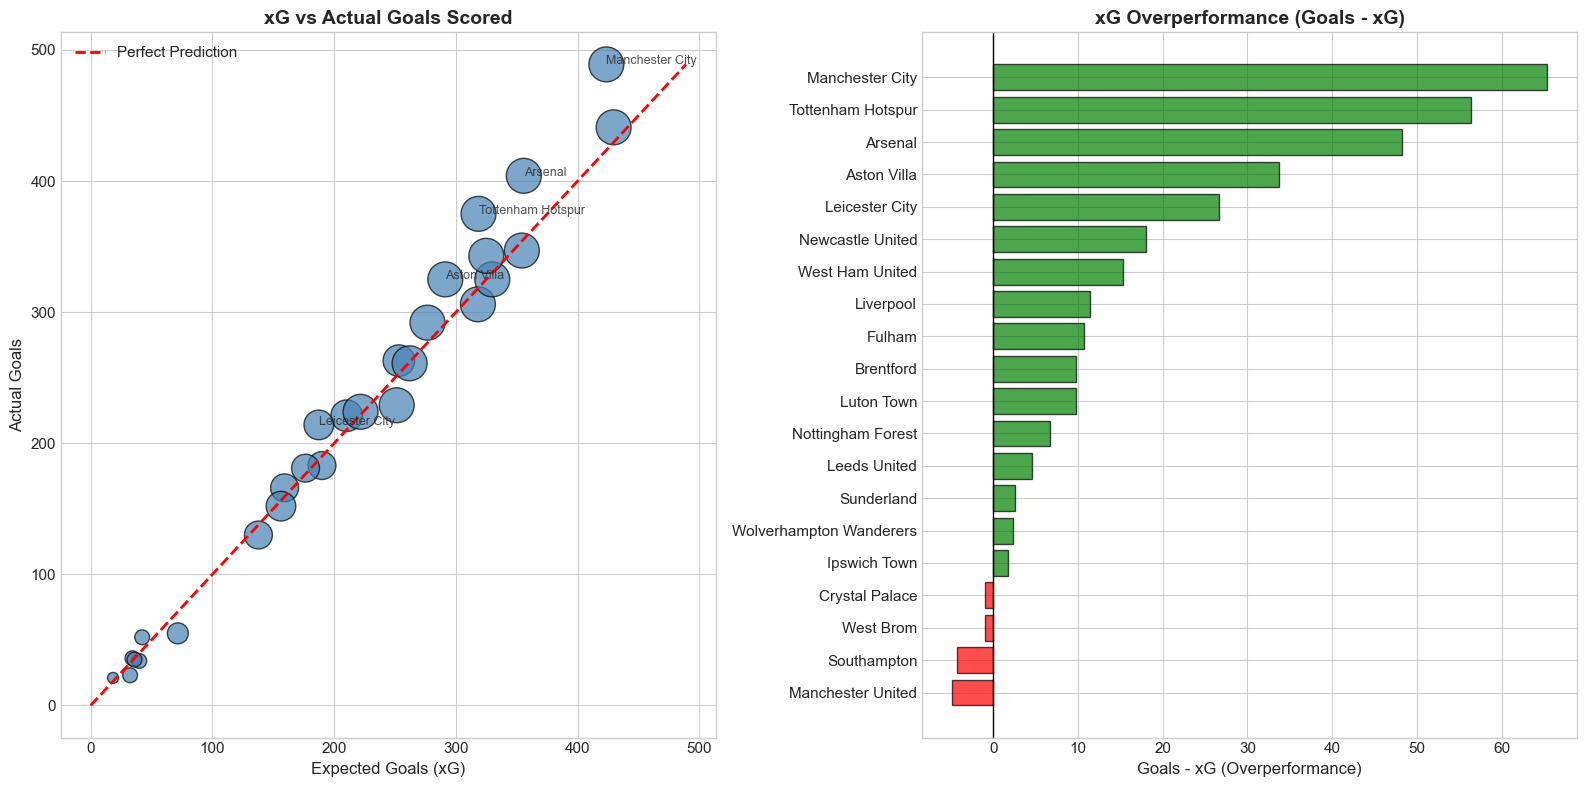


Top xG Overperformers (Scored more than expected):


,team,goals_for,xg_for,xg_overperformance,matches
15,Manchester City,489.0,423.6,65.4,211
23,Tottenham Hotspur,375.0,318.6,56.4,211
0,Arsenal,404.0,355.8,48.2,211
1,Aston Villa,325.0,291.3,33.7,211
12,Leicester City,214.0,187.4,26.6,152
17,Newcastle United,343.0,325.0,18.0,211
26,West Ham United,292.0,276.7,15.3,211
13,Liverpool,441.0,429.6,11.4,211
9,Fulham,221.0,210.3,10.7,173
3,Brentford,263.0,253.2,9.8,173


In [4]:
# xG vs Actual Goals Analysis
team_agg['xg_overperformance'] = team_agg['goals_for'] - team_agg['xg_for']
team_agg['xg_defense_performance'] = team_agg['xg_against'] - team_agg['goals_against']

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# xG vs Actual Goals scatter
axes[0].scatter(team_agg['xg_for'], team_agg['goals_for'], 
                s=team_agg['matches']*3, alpha=0.7, c='steelblue', edgecolors='black')

# Add diagonal line (perfect prediction)
max_val = max(team_agg['xg_for'].max(), team_agg['goals_for'].max())
axes[0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')

# Label top overperformers
top_overperformers = team_agg.nlargest(5, 'xg_overperformance')
for _, row in top_overperformers.iterrows():
    axes[0].annotate(row['team'], (row['xg_for'], row['goals_for']), 
                     fontsize=9, alpha=0.8)

axes[0].set_xlabel('Expected Goals (xG)', fontsize=12)
axes[0].set_ylabel('Actual Goals', fontsize=12)
axes[0].set_title('xG vs Actual Goals Scored', fontsize=14, fontweight='bold')
axes[0].legend()

# xG Overperformance bar chart
overperf = team_agg.nlargest(20, 'xg_overperformance')[['team', 'xg_overperformance']]
colors_over = ['green' if x > 0 else 'red' for x in overperf['xg_overperformance']]
bars = axes[1].barh(overperf['team'], overperf['xg_overperformance'], color=colors_over, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='black', linewidth=1)
axes[1].set_xlabel('Goals - xG (Overperformance)', fontsize=12)
axes[1].set_title('xG Overperformance (Goals - xG)', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../notebooks/figures/xg_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop xG Overperformers (Scored more than expected):")
display(team_agg.nlargest(10, 'xg_overperformance')[['team', 'goals_for', 'xg_for', 'xg_overperformance', 'matches']])

## 4. Season-by-Season Performance

In [5]:
# Calculate team stats per season
def season_team_stats(fixtures_df):
    """Calculate team statistics per season."""
    results = []
    
    for season in fixtures_df['season'].unique():
        season_data = fixtures_df[fixtures_df['season'] == season]
        season_stats = calculate_team_stats(season_data)
        season_stats['season'] = season
        results.append(season_stats)
    
    return pd.concat(results, ignore_index=True)

season_stats = season_team_stats(fixtures)
display(Markdown(f"**Season-by-season stats shape:** {season_stats.shape}"))

**Season-by-season stats shape:** (120, 27)

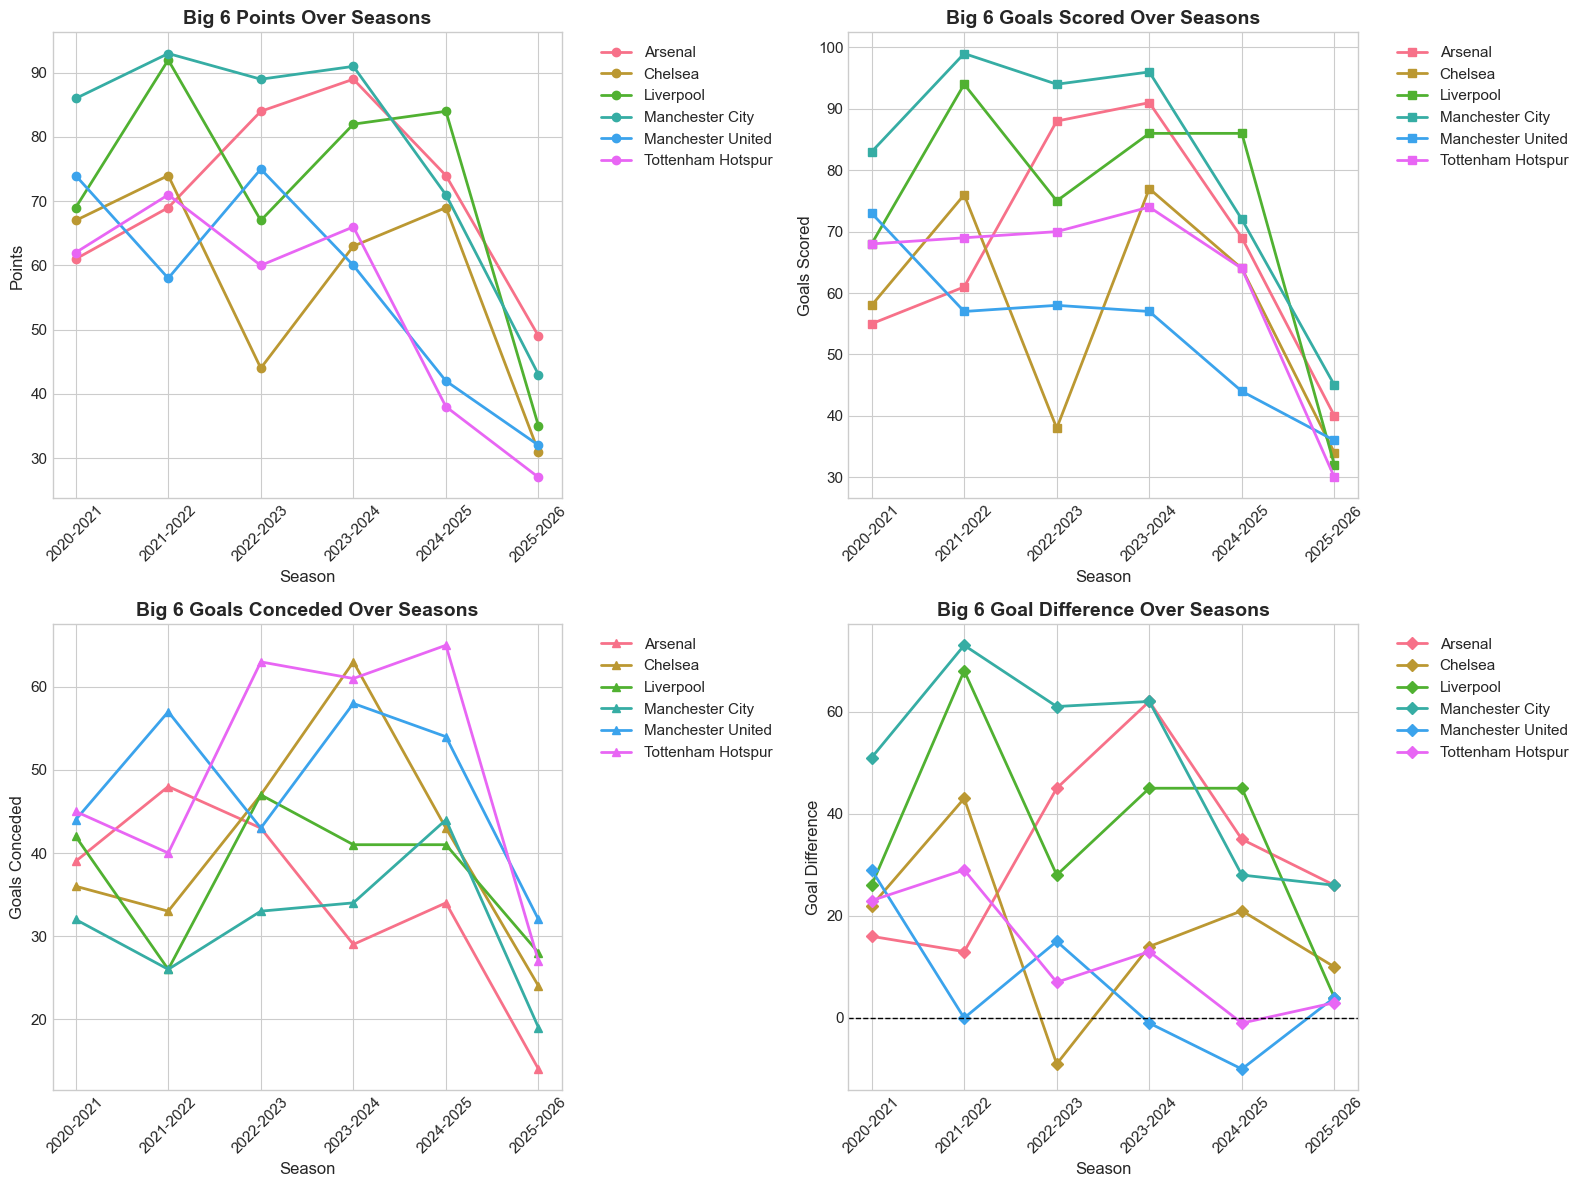

In [6]:
# Top teams performance over seasons (Big 6)
big_6 = ['Arsenal', 'Chelsea', 'Liverpool', 'Manchester City', 'Manchester United', 'Tottenham Hotspur']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Points over seasons
for team in big_6:
    team_data = season_stats[season_stats['team'] == team].sort_values('season')
    if len(team_data) > 0:
        axes[0, 0].plot(team_data['season'], team_data['points'], marker='o', linewidth=2, label=team)

axes[0, 0].set_xlabel('Season', fontsize=12)
axes[0, 0].set_ylabel('Points', fontsize=12)
axes[0, 0].set_title('Big 6 Points Over Seasons', fontsize=14, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Goals scored over seasons
for team in big_6:
    team_data = season_stats[season_stats['team'] == team].sort_values('season')
    if len(team_data) > 0:
        axes[0, 1].plot(team_data['season'], team_data['goals_for'], marker='s', linewidth=2, label=team)

axes[0, 1].set_xlabel('Season', fontsize=12)
axes[0, 1].set_ylabel('Goals Scored', fontsize=12)
axes[0, 1].set_title('Big 6 Goals Scored Over Seasons', fontsize=14, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Goals conceded over seasons
for team in big_6:
    team_data = season_stats[season_stats['team'] == team].sort_values('season')
    if len(team_data) > 0:
        axes[1, 0].plot(team_data['season'], team_data['goals_against'], marker='^', linewidth=2, label=team)

axes[1, 0].set_xlabel('Season', fontsize=12)
axes[1, 0].set_ylabel('Goals Conceded', fontsize=12)
axes[1, 0].set_title('Big 6 Goals Conceded Over Seasons', fontsize=14, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Goal difference over seasons
for team in big_6:
    team_data = season_stats[season_stats['team'] == team].sort_values('season')
    if len(team_data) > 0:
        axes[1, 1].plot(team_data['season'], team_data['goal_diff'], marker='D', linewidth=2, label=team)

axes[1, 1].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1, 1].set_xlabel('Season', fontsize=12)
axes[1, 1].set_ylabel('Goal Difference', fontsize=12)
axes[1, 1].set_title('Big 6 Goal Difference Over Seasons', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('../notebooks/figures/big6_trends.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Home vs Away Performance

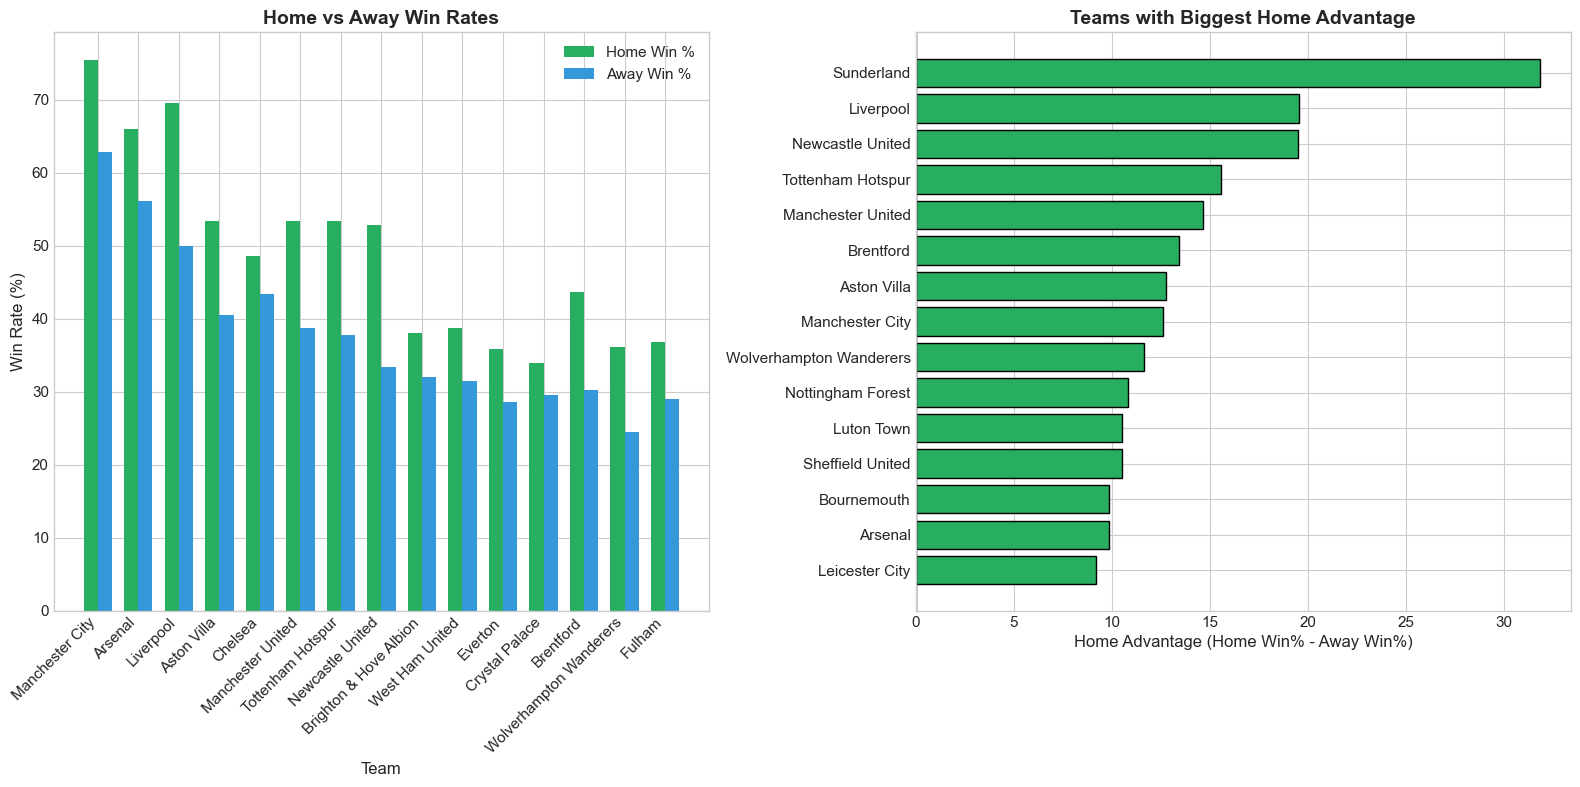


## 🏠 Overall League Statistics

| Metric | Value |
|--------|-------|
| Home Win Rate | **43.4%** |
| Away Win Rate | **33.5%** |
| Draw Rate | **23.1%** |
| Home Advantage | **10.0%** |


In [7]:
# Home vs Away analysis
team_agg['home_win_rate'] = team_agg['home_wins'] / team_agg['home_matches'] * 100
team_agg['away_win_rate'] = team_agg['away_wins'] / team_agg['away_matches'] * 100
team_agg['home_advantage'] = team_agg['home_win_rate'] - team_agg['away_win_rate']

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Home vs Away win rates
top_teams = team_agg.nlargest(15, 'wins')[['team', 'home_win_rate', 'away_win_rate']]
x = np.arange(len(top_teams))
width = 0.35

bars1 = axes[0].bar(x - width/2, top_teams['home_win_rate'], width, label='Home Win %', color='#27ae60')
bars2 = axes[0].bar(x + width/2, top_teams['away_win_rate'], width, label='Away Win %', color='#3498db')

axes[0].set_xlabel('Team', fontsize=12)
axes[0].set_ylabel('Win Rate (%)', fontsize=12)
axes[0].set_title('Home vs Away Win Rates', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(top_teams['team'], rotation=45, ha='right')
axes[0].legend()

# Home advantage
home_adv = team_agg.nlargest(15, 'home_advantage')[['team', 'home_advantage']]
colors_adv = ['#27ae60' if x > 0 else '#e74c3c' for x in home_adv['home_advantage']]
bars = axes[1].barh(home_adv['team'], home_adv['home_advantage'], color=colors_adv, edgecolor='black')
axes[1].axvline(0, color='black', linewidth=1)
axes[1].set_xlabel('Home Advantage (Home Win% - Away Win%)', fontsize=12)
axes[1].set_title('Teams with Biggest Home Advantage', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../notebooks/figures/home_away_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Overall home advantage
overall_home_win_pct = (fixtures['match_result'] == 2).mean() * 100
overall_away_win_pct = (fixtures['match_result'] == 0).mean() * 100
overall_draw_pct = (fixtures['match_result'] == 1).mean() * 100

display(Markdown(f"""
## 🏠 Overall League Statistics

| Metric | Value |
|--------|-------|
| Home Win Rate | **{overall_home_win_pct:.1f}%** |
| Away Win Rate | **{overall_away_win_pct:.1f}%** |
| Draw Rate | **{overall_draw_pct:.1f}%** |
| Home Advantage | **{overall_home_win_pct - overall_away_win_pct:.1f}%** |
"""))

## 6. Performance Summary

In [8]:
# Create comprehensive league table
league_table = team_agg[['team', 'matches', 'wins', 'draws', 'losses', 'goals_for', 
                         'goals_against', 'goal_diff', 'xg_for', 'xg_against', 'points']].copy()
league_table = league_table.sort_values('points', ascending=False).reset_index(drop=True)
league_table.index = league_table.index + 1

display(Markdown("## 🏆 ALL-TIME PREMIER LEAGUE TABLE (Dataset Period)"))
display(league_table.round(1))

## 🏆 ALL-TIME PREMIER LEAGUE TABLE (Dataset Period)

,team,matches,wins,draws,losses,goals_for,goals_against,goal_diff,xg_for,xg_against,points
1,Manchester City,211,146,35,30,489.0,188.0,301.0,423.6,193.4,473
2,Liverpool,211,126,51,34,441.0,225.0,216.0,429.6,235.8,429
3,Arsenal,211,129,39,43,404.0,207.0,197.0,355.8,207.5,426
4,Chelsea,211,97,57,57,347.0,246.0,101.0,354.2,249.4,348
5,Manchester United,211,97,50,64,325.0,288.0,37.0,329.9,294.4,341
6,Aston Villa,211,99,41,71,325.0,282.0,43.0,291.3,293.0,338
7,Tottenham Hotspur,211,96,36,79,375.0,301.0,74.0,318.6,291.6,324
8,Newcastle United,211,91,50,70,343.0,293.0,50.0,325.0,285.7,323
9,Brighton & Hove Albion,211,74,70,67,306.0,292.0,14.0,318.1,268.4,292
10,West Ham United,211,74,48,89,292.0,332.0,-40.0,276.7,321.7,270


In [9]:
# Key insights summary
best_attack = team_agg.loc[team_agg['goals_for'].idxmax()]
best_defense_team = team_agg.loc[team_agg['goals_against'].idxmin()]
most_points = team_agg.loc[team_agg['points'].idxmax()]
xg_over = team_agg.loc[team_agg['xg_overperformance'].idxmax()]

display(Markdown(f"""
# 📊 KEY INSIGHTS - TEAM PERFORMANCE ANALYSIS

---

## ⚽ Best Attack: **{best_attack['team']}**
| Metric | Value |
|--------|-------|
| Goals Scored | **{best_attack['goals_for']:.0f}** |
| Goals per Match | **{best_attack['goals_for']/best_attack['matches']:.2f}** |

---

## 🛡️ Best Defense: **{best_defense_team['team']}**
| Metric | Value |
|--------|-------|
| Goals Conceded | **{best_defense_team['goals_against']:.0f}** |
| Goals Conceded per Match | **{best_defense_team['goals_against']/best_defense_team['matches']:.2f}** |

---

## 🏆 Most Successful: **{most_points['team']}**
| Metric | Value |
|--------|-------|
| Total Points | **{most_points['points']:.0f}** |
| Wins | **{most_points['wins']:.0f}** |
| Points per Match | **{most_points['points']/most_points['matches']:.2f}** |

---

## 🎯 Biggest xG Overperformer: **{xg_over['team']}**
- Scored **{xg_over['xg_overperformance']:.1f}** more goals than expected
"""))


# 📊 KEY INSIGHTS - TEAM PERFORMANCE ANALYSIS

---

## ⚽ Best Attack: **Manchester City**
| Metric | Value |
|--------|-------|
| Goals Scored | **489** |
| Goals per Match | **2.32** |

---

## 🛡️ Best Defense: **Sunderland**
| Metric | Value |
|--------|-------|
| Goals Conceded | **22** |
| Goals Conceded per Match | **1.05** |

---

## 🏆 Most Successful: **Manchester City**
| Metric | Value |
|--------|-------|
| Total Points | **473** |
| Wins | **146** |
| Points per Match | **2.24** |

---

## 🎯 Biggest xG Overperformer: **Manchester City**
- Scored **65.4** more goals than expected
